In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM
from keras.layers import Bidirectional

In [ ]:
# load train and test datasets
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [ ]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.isnull().sum().sort_values(ascending = False)

location    2533
keyword       61
target         0
text           0
id             0
dtype: int64

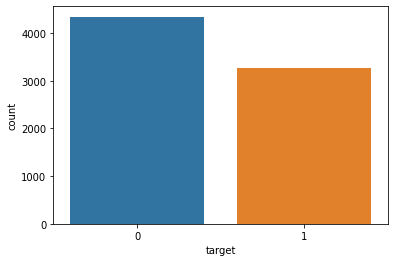

In [ ]:
sns.countplot(x=train.target)

In [ ]:
nltk.download('stopwords')
stop = list(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# save list of punctuation/special characters in a variable
punctuation = list(string.punctuation)

In [ ]:
# create an object to convert the words to its lemma form
lemma = WordNetLemmatizer()

In [ ]:
# lets make a combine list of stopwords and punctuations
sw_pun = stop + punctuation

In [ ]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [ ]:
# apply preprocessing functions on the train and test datasets
nltk.download('wordnet')
train['text'] = train['text'].apply(lambda s : preprocess(s))
test ['text'] = test ['text'].apply(lambda s : preprocess(s))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# applying the function on the train and the test datasets
train['text'] = train['text'].apply(lambda s : remove_emoji(s))
test ['text'] = test ['text'].apply(lambda s : remove_emoji(s))

In [ ]:
# function to create vocab
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)

In [ ]:
# concatenate training and testing datasets
master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
len(vocab)

16442

In [ ]:
# lets check the most common 50 words in the vocabulary
vocab.most_common(50)

[('like', 560),
 ('fire', 534),
 ('bomb', 338),
 ('news', 299),
 ('people', 286),
 ('burn', 262),
 ('time', 254),
 ('kill', 253),
 ('make', 248),
 ('attack', 240),
 ('flood', 233),
 ('crash', 232),
 ('build', 231),
 ('emergency', 229),
 ('video', 228),
 ('come', 223),
 ('disaster', 220),
 ('take', 217),
 ('would', 214),
 ('body', 209),
 ('think', 204),
 ('police', 199),
 ('look', 193),
 ('know', 192),
 ('love', 190),
 ('watch', 188),
 ('home', 187),
 ('storm', 187),
 ('still', 181),
 ('train', 177),
 ('suicide', 177),
 ('live', 172),
 ('first', 170),
 ('collapse', 169),
 ('back', 164),
 ('scream', 164),
 ('california', 159),
 ('want', 156),
 ('drown', 152),
 ('cause', 151),
 ('need', 150),
 ('work', 149),
 ('today', 149),
 ('world', 148),
 ('nuclear', 148),
 ('hiroshima', 147),
 ('year', 143),
 ('full', 143),
 ('service', 142),
 ('destroy', 138)]

In [ ]:
# create the final vocab by considering words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [ ]:
# lets check the no. of the words in the final vocabulary
vocab_size = len(final_vocab)
vocab_size

6025

In [ ]:
# function to filter the dataset, keep only words which are present in the vocab
def filter(tweet):
    sentence = ""
    for word in tweet.split():  
        if word in final_vocab:
            sentence = sentence + word + ' '
    return(sentence)

In [ ]:
# apply filter function on the train and test datasets
train['text'] = train['text'].apply(lambda s : filter(s))
test ['text'] = test ['text'].apply(lambda s : filter(s))

In [ ]:
# lets take a look at the update training dataset
train.text.head()

0               deeds reason earthquake allah forgive 
1                             forest fire near canada 
2    residents shelter place officer evacuation she...
3    people receive wildfires evacuation order cali...
4    send photo ruby alaska smoke wildfires pour sc...
Name: text, dtype: object

In [ ]:
# the different units into which you can break down text (words, characters, or n-grams) are called tokens, 
# and breaking text into such tokens is called tokenization, this can be achieved using Tokenizer in Keras

from keras.preprocessing.text import Tokenizer
# fit a tokenizer
def create_tokenizer(lines):
    # num_words = vocab_size will create a tokenizer,configured to only take into account the vocab_size(6025)
    tokenizer = Tokenizer(num_words=vocab_size)
    # Build th word index, Turns strings into lists of integer indices
    tokenizer.fit_on_texts(lines) 
    return tokenizer

In [ ]:
# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(train.text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5792 unique tokens.


In [ ]:
# converting texts into vectors
train_text = tokenizer.texts_to_matrix(train.text, mode = 'freq')

In [ ]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(train_text, train.target, test_size = 0.2, random_state = 42)

In [ ]:
# function to calculate f1 score for each epoch
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(1024, input_shape=(n_words,), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [get_f1])
    
    # summarize defined model
    model.summary()
    return model

In [ ]:
X_train.shape

(6090, 6025)

In [ ]:
# create the model
n_words = X_train.shape[1]
model = define_model(n_words)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              6170624   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [ ]:
#fit network
history = model.fit(X_train,y_train,epochs=20,verbose=2,validation_split=0.2)

Epoch 1/20
153/153 - 8s - loss: 0.5485 - get_f1: 0.4959 - val_loss: 0.4813 - val_get_f1: 0.7093
Epoch 2/20
153/153 - 7s - loss: 0.3187 - get_f1: 0.8346 - val_loss: 0.5171 - val_get_f1: 0.6859
Epoch 3/20
153/153 - 7s - loss: 0.1901 - get_f1: 0.9171 - val_loss: 0.5886 - val_get_f1: 0.7052
Epoch 4/20
153/153 - 7s - loss: 0.1202 - get_f1: 0.9458 - val_loss: 0.8119 - val_get_f1: 0.7343
Epoch 5/20
153/153 - 7s - loss: 0.0773 - get_f1: 0.9617 - val_loss: 0.9373 - val_get_f1: 0.7179
Epoch 6/20
153/153 - 7s - loss: 0.0595 - get_f1: 0.9672 - val_loss: 1.2394 - val_get_f1: 0.7113
Epoch 7/20
153/153 - 7s - loss: 0.0554 - get_f1: 0.9695 - val_loss: 1.0601 - val_get_f1: 0.7180
Epoch 8/20
153/153 - 7s - loss: 0.0481 - get_f1: 0.9702 - val_loss: 1.4373 - val_get_f1: 0.7286
Epoch 9/20
153/153 - 7s - loss: 0.0451 - get_f1: 0.9711 - val_loss: 1.2632 - val_get_f1: 0.7243
Epoch 10/20
153/153 - 7s - loss: 0.0436 - get_f1: 0.9718 - val_loss: 1.5230 - val_get_f1: 0.7276
Epoch 11/20
153/153 - 7s - loss: 0.0460

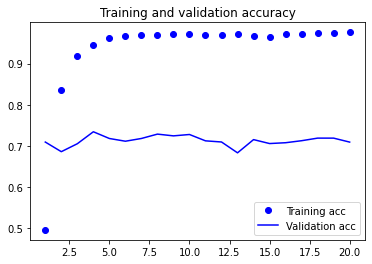

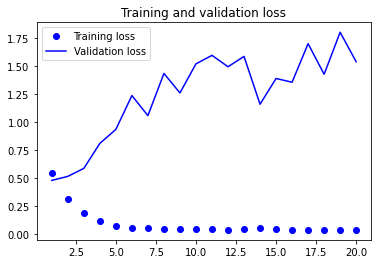

In [ ]:
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = model.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# important metrices
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       874
           1       0.70      0.71      0.70       649

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523

